# IMO zadanie 3

**Wykorzystanie ocen ruchów z poprzednich iteracji i ruchów kandydackich w loklanym przeszukiwaniu**

**Autorki** <br />
Emilia Maciejewska 136764<br />
Anita Zielińska 136836

In [300]:
import tsplib95
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import datetime
import copy

# 0. Wczytywanie danych

In [301]:
problemA = tsplib95.load("kroA200.tsp")
problemA = problemA.as_keyword_dict()

In [302]:
problemB = tsplib95.load("kroB200.tsp")
problemB = problemB.as_keyword_dict()

In [303]:
def create_distance_matrix(data):
    dict_length = len(data['NODE_COORD_SECTION'])
    distance_matrix = np.zeros((dict_length, dict_length), dtype=int)
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix[i])):
            x1 = data['NODE_COORD_SECTION'][i+1]
            x2 = data['NODE_COORD_SECTION'][j+1]
            d = math.floor(math.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) + 0.5)
            distance_matrix[i][j] = d
    return distance_matrix

In [304]:
distance_matrix_A = create_distance_matrix(problemA)
distance_matrix_B = create_distance_matrix(problemB)

# 1. Algorytm startowy (losowy)

In [305]:
def random_start(experimentId, p1, p2):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    matrix_length = len(mat) 
    d_matrix = []

    result = [[],[]]
    resultVal = [[0],[0]]
    cycleId = 0
    for point in sorted(list(range(matrix_length)), key=lambda x:random.random()):
        result[cycleId].append(point)
        if len(result[cycleId]) > 1:
            resultVal[cycleId] += mat[result[cycleId][-2]][result[cycleId][-1]]
        cycleId = 0 if cycleId else 1
        
    resultVal[0] += mat[result[0][-1]][result[0][0]]
    resultVal[1] += mat[result[1][-1]][result[1][0]]
    result[0].append(result[0][0])
    result[1].append(result[1][0]) 
    return result, resultVal

# 2. Punkty odniesienia

### Wybór punktów początkowych

In [306]:
def selectStartingPoints(id):
    if id == 'A':
        max_id = max_id = len(distance_matrix_A) - 1 
    else:
        max_id = max_id = len(distance_matrix_B) - 1 
    p1 = random.randint(0, max_id)
    p2 = random.randint(0, max_id)
    while p2 == p1:
        p2 = random.randint(0, max_id)
    return p1, p2

In [307]:
def selectP(experimentId):
    p1 = 0
    p2 = 0
    while True:
        p1, p2 = selectStartingPoints(experimentId)
        sId1 = str(p1)+","+str(p2)
        sId2 = str(p2)+","+str(p1)
        if sId1 not in startingPoints and sId2 not in startingPoints:
            startingPoints[sId1] = 1
            break
    return p1, p2

## 2.1 Heurystyka zachłanna najbliższego sąsiada

In [308]:
def greedy_start(experimentId, p1, p2):
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]

    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        for i in range(matrix_length):
            if i not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new.append(i)
                    new += result[cycleId][j:]
                    dist = 0
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = i
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    resultVal[0] += d_matrix[result[0][len(result[0]) - 1]][result[0][0]]
    resultVal[1] += d_matrix[result[1][len(result[1]) - 1]][result[1][0]]
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    return result, resultVal

## 2.2. Lokalne przeszukiwanie w wersji stromej (wierzchołki + krawędzie)

### 2.2.1 Sąsiedztwo międzytrasowe wierzchołki

In [309]:
def neighborExternalV (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    for i in range(1, len(aA)-1):
        for j in range(1, len(aB)-1):
            dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
            dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
            dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
            dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
            d = dis2 - dis1
            if d < delta:
                delta = d
                r = [aA[i], aB[j]]
    return delta, r

### 2.2.2 Sąsiedztwo wewnątrztrasowe krawędzie

In [310]:
def neighborInternalESingle (mat, aA, delta, r):
    for i in range(1, len(aA)):
        for j in range(i+1,  len(aA)-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0 and d < delta:
                    delta = d
                    r = [aA[i], aA[j]]
    return delta, r

In [311]:
def neighborInternalE (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    delta1, r1 = neighborInternalESingle(mat, aA, delta, r)
    delta2, r2 = neighborInternalESingle(mat, aB, delta, r)
    if delta1 < delta2:
        return delta1, r1, "0"
    else:
        return delta2, r2, "1"

### 2.2.3 Lokalne przeszukiwanie

In [312]:
def steepestE (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        delta1, r1 = neighborExternalV(experimentId, result, resultVal)
        delta2, r2, cycleId = neighborInternalE(experimentId, result, resultVal)
        if delta1 < delta2: # lepsza była zmiana międzytrasowa
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        else:
            r = r2
            tempA = []
            cycleId = int(cycleId)
            index1 = np.where(result[cycleId] == r[0])
            index2 = np.where(result[cycleId] == r[1])
            tempA = np.copy(result[cycleId])
            tempA = tempA[index1[0][0]+1: index2[0][0]]
            
            if cycleId == 1:
                newResultVal[0] = np.copy(resultVal[0])
                newResult[0] = np.copy(result[0])
            else:
                newResultVal[1] = np.copy(resultVal[1])
                newResult[1] = np.copy(result[1])
            
            tempA = np.flip(tempA)
            flag = False
            ind = 0
            for j in range(len(result[cycleId])):
                if result[cycleId][j] == r[0]:
                    newResult[cycleId].append(r[1])
                    ind = 0
                    flag = True
                elif result[cycleId][j] == r[1]:
                    newResult[cycleId].append(r[0])
                    flag = False
                elif flag == True:
                    newResult[cycleId].append(tempA[ind])
                    ind +=1
                else:
                    newResult[cycleId].append(result[cycleId][j])
                if len(newResult[cycleId]) > 1:
                    newResultVal[cycleId] += mat[newResult[cycleId][-2]][newResult[cycleId][-1]]

        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
        
    return result, resultVal

# 3. Algorytm lokalnego przeszukiwania z listą ruchów

In [313]:
def neighborExternalLM (experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    for i in range(1, len(aA)-1):
        for j in range(1, len(aB)-1):
            key_1 = str(aA[i-1])+","+str(aA[i])+","+str(aA[i+1])+","+str(aB[j-1])+","+str(aB[j])+","+str(aB[j+1]) 
            if key_1 not in LM: 
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    LM[key_1] = d

In [314]:
def neighborInternalLMSingle (mat, aA):
    for i in range(0, len(aA)-1):
        for j in range(i+2,  len(aA)-1):
            if i+2 != j:
                key_1 = str(aA[i])+","+str(aA[i+1])+","+str(aA[j])+","+str(aA[j+1])
                if key_1 not in LM:
                    dis1 = mat[aA[i]][aA[i+1]] + mat[aA[j]][aA[j+1]]
                    dis2 = mat[aA[i]][aA[j]] + mat[aA[i+1]][aA[j+1]]
                    d = dis2 - dis1
                    if d < 0:
                        LM[key_1] = d  

In [315]:
def neighborInternalLM (experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    aA = copy.copy(result[0])
    aB = copy.copy(result[1])
    neighborInternalLMSingle(mat, aA)
    neighborInternalLMSingle(mat, aB)

In [316]:
def updateAfterVertices1(experimentId, result, changes):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    aA = np.append(aA, aA[2])
    if changes[0] < 2:
        changes[0] = changes[0] + len(result[0]) - 1
        aA = np.append(aA, aA[3])
        
    for i in range(changes[0]-1, changes[0]+2):
        for j in range(1, len(result[1])):
            key_1 = str(aA[i-1])+","+str(aA[i])+","+str(aA[i+1])+","+str(aB[j-1])+","+str(aB[j])+","+str(aB[j+1]) 
            if key_1 not in LM:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    LM[key_1] = d
                
    aB = np.append(aB, aB[2])
    if changes[1] < 2:
        changes[1] = changes[1] + len(result[1]) - 1
        aB = np.append(aB, aB[3])    
    for i in range(1, len(result[0])):
        for j in range(changes[1] - 1, changes[1]+2):
            key_1 = str(aA[i-1])+","+str(aA[i])+","+str(aA[i+1])+","+str(aB[j-1])+","+str(aB[j])+","+str(aB[j+1]) 
            if key_1 not in LM:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    LM[key_1] = d

In [317]:
def updateAfterVertices2(experimentId, result, changes):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    aA = copy.copy(result[0])
    aB = copy.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1])
    if (changes[0] >= len(result[0])-1):
        changes[0] = changes[0] - len(result[0])-1
    if (changes[1] >= len(result[1])-1):
        changes[1] = changes[1] - len(result[1])-1
    
    for i in range(0, len(result[0])-1):
        for j in range(changes[0],  changes[0]+2):
            if i!=j and i+1!= j and i+2 != j:
                key_1 = str(aA[i])+","+str(aA[i+1])+","+str(aA[j])+","+str(aA[j+1])
                if key_1 not in LM:
                    dis1 = mat[aA[i]][aA[i+1]] + mat[aA[j]][aA[j+1]]
                    dis2 = mat[aA[i]][aA[j]] + mat[aA[i+1]][aA[j+1]]
                    d = dis2 - dis1
                    if d < 0:
                        LM[key_1] = d  
                    
    for i in range(0, len(result[1])-1):
        for j in range(changes[1],  changes[1]+2):
            if i!=j and i+1!= j and i+2 != j:
                key_1 = str(aB[i])+","+str(aB[i+1])+","+str(aB[j])+","+str(aB[j+1])
                if key_1 not in LM:
                    dis1 = mat[aB[i]][aB[i+1]] + mat[aB[j]][aB[j+1]]
                    dis2 = mat[aB[i]][aB[j]] + mat[aB[i+1]][aB[j+1]]
                    d = dis2 - dis1
                    if d < 0:
                        LM[key_1] = d 

In [318]:
def updateAfterEdges1(experimentId, result, cycleId, changes):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    aA = np.copy(result[cycleId])
    nextId = 0
    if cycleId == 0:
        newxtId = 1
    aB = np.copy(result[nextId])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    aA = np.append(aA, aA[2])
    if changes[0] < 1:
        changes[0] = changes[0] + len(result[cycleId]) - 1
    if changes[1] < 1:
        changes[1] = changes[1] + len(result[cycleId]) - 1
               
    for i in range(changes[0], changes[0]+2):
        for j in range(1, len(result[nextId])):
            key_1 = str(aA[i-1])+","+str(aA[i])+","+str(aA[i+1])+","+str(aB[j-1])+","+str(aB[j])+","+str(aB[j+1]) 
            if key_1 not in LM:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    LM[key_1] = d
    for i in range(changes[1], changes[1]+2):
        for j in range(1, len(result[nextId])):
            key_1 = str(aA[i-1])+","+str(aA[i])+","+str(aA[i+1])+","+str(aB[j-1])+","+str(aB[j])+","+str(aB[j+1])
            if key_1 not in LM:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    LM[key_1] = d


In [319]:
def updateAfterEdges2(experimentId, result, cycleId, changes):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    aA = copy.copy(result[cycleId])
    aA = np.append(aA, aA[1])
    if (changes[0] >= len(result[cycleId])-1):
        changes[0] = changes[0] - len(result[cycleId])-1
    if (changes[1] >= len(result[cycleId])-1):
        changes[1] = changes[1] - len(result[cycleId])-1
    
    for i in range(0, len(result[cycleId])-1):
        j = changes[0]
        if i!=j and i+1!= j and i+2 != j:
            key_1 = str(aA[i])+","+str(aA[i+1])+","+str(aA[j])+","+str(aA[j+1])
            if key_1 not in LM:
                dis1 = mat[aA[i]][aA[i+1]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i]][aA[j]] + mat[aA[i+1]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    LM[key_1] = d  
        j = changes[1]
        if i!=j and i+1!= j and i+2 != j:
            key_1 = str(aA[i])+","+str(aA[i+1])+","+str(aA[j])+","+str(aA[j+1])
            if key_1 not in LM:
                dis1 = mat[aA[i]][aA[i+1]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i]][aA[j]] + mat[aA[i+1]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    LM[key_1] = d 

In [320]:
def checkEdges(k, vert, res):
    res_copy = copy.deepcopy(res)
    
    r2 = []
    e1 = False
    e2 = False
    e1_r = False
    e2_r = False
    cycleId1 = 0
    cycleId2 = 0
    i1 = 0
    i2 = 0

    for c in range(len(res_copy)):
        if (e1 == True or e1_r == True) and (e2 == True or e2_r == True):
            break
        for i in range(1, len(res_copy[c])-1):
            if (e1 == True or e1_r == True) and (e2 == True or e2_r == True):
                break
            if int(vert[0]) == res_copy[c][i] and int(vert[1]) == res_copy[c][i+1]:
                e1 = True
                cycleId1 = c
                i1 = i 
            if int(vert[2]) == res_copy[c][i] and int(vert[3]) == res_copy[c][i+1]:
                e2 = True
                cycleId2 = c
                i2 = i
            if int(vert[1]) == res_copy[c][i] and int(vert[0]) == res_copy[c][i+1]:
                e1_r = True
                cycleId1 = c
                i1 = i
            if int(vert[3]) == res_copy[c][i] and int(vert[2]) == res_copy[c][i+1]:
                e2_r = True
                cycleId2 = c
                i2 = i
    if (e1 == False and e1_r == False) or (e2 == False and e2_r == False):
        LM.pop(k)
        return False, [], cycleId1, []
    elif e1 == True and e2 == True and cycleId1 == cycleId2:
        if i1<i2:
            return True, [int(vert[0]), int(vert[2])], cycleId1, [i1, i2]
        else:
            return True, [int(vert[2]), int(vert[0])], cycleId1, [i2, i1]
    elif e1_r == True and e2_r == True and cycleId1 == cycleId2:
        if i1<i2:
            return True, [int(vert[1]), int(vert[3])], cycleId1, [i1, i2]
        else:
            return True, [int(vert[3]), int(vert[1])], cycleId1, [i2, i1]
    else:
        return False, [], cycleId1, []

In [321]:
def checkVertex(k, vert, res):
    res_copy = copy.deepcopy(res)
    res_copy[0] = np.append(res_copy[0], res_copy[0][1])
    res_copy[1] = np.append(res_copy[1], res_copy[1][1])
    
    id1 = False
    id2 = False
    cycleId1 = 0
    cycleId2 = 0
    index1 = 0
    index2 = 0


    for c in range (len(res_copy)):
        if id1 == True and id2 == True:
                break
        for i in range(1, len(res_copy[c])-1):
            if id1 == True and id2 == True:
                break
            if res_copy[c][i] == int(vert[1]) and res_copy[c][i-1] == int(vert[0]) and res_copy[c][i+1] == int(vert[2]):
                id1 = True
                index1 = i
                cycleId1 = c
            elif res_copy[c][i] == int(vert[1]) and res_copy[c][i-1] == int(vert[2]) and res_copy[c][i+1] == int(vert[0]):
                id1 = True
                index1 = i
                cycleId1 = c
            elif res_copy[c][i] == int(vert[4]) and res_copy[c][i-1] == int(vert[3]) and res_copy[c][i+1] == int(vert[5]):
                id2 = True
                index2 = i
                cycleId2 = c
            elif res_copy[c][i] == int(vert[4]) and res_copy[c][i-1] == int(vert[5]) and res_copy[c][i+1] == int(vert[3]):
                id2 = True
                index2 = i
                cycleId2 = c
    if id1 == True and id2 == True and cycleId1 != cycleId2:
        if cycleId1 == 0:
            return True, [int(vert[1]), int(vert[4])], [index1, index2]
        elif cycleId2 == 0:
            return True, [int(vert[4]), int(vert[1])], [index2, index1]
    else:
        LM.pop(k)  
        return False, [], []

In [322]:
def steepestLM (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    r1 = []
    r2 = []
    changes = []
    cycleId = 0
    neighborExternalLM(experimentId, result)
    neighborInternalLM(experimentId, result)
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        

        if len(LM) > 0: 
            cycleId = 0
            nType = 0
            sorted_dict = {}
            sorted_keys = sorted(LM, key=LM.get)

            for w in sorted_keys:
                sorted_dict[w] = LM[w]
                
            for k in sorted_dict:
                vertices = k.split(",")
                if len(vertices) == 4:
                    nType = 1
                    good, r2, cycleId, ids = checkEdges(k, vertices, result)
                    if good == True:
                        break
                        
                elif len(vertices) == 6:
                    nType = 0
                    good, r1, ids = checkVertex(k, vertices, result)
                    if good == True:
                        break

                        
                else:
                    print("błąd")
                    return result, resultVal

        
        if len(LM) > 0 and nType == 0 and good == True: #zamiana wierzchołków
            r = r1
            changes = [0,0]
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                        changes[0] = j
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                        changes[1] = j
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
            updateAfterVertices1(experimentId, newResult, changes)
            updateAfterVertices2(experimentId, newResult, changes)
            
        elif len(LM) > 0 and nType == 1 and good == True: #zamiana krawędzi
            r = r2
            tempA = []
            index1 = ids[0]
            index2 = ids[1]
            tempA = copy.copy(result[cycleId])
            tempA = tempA[index1+1: index2+1]
            
            if cycleId == 1:
                newResultVal[0] = copy.copy(resultVal[0])
                newResult[0] = copy.copy(result[0])
            else:
                newResultVal[1] = copy.copy(resultVal[1])
                newResult[1] = copy.copy(result[1])
            
            tempA = np.flip(tempA)
            flag = False
            ind = 0
            for j in range(len(result[cycleId])):
                if result[cycleId][j] == r[0]:
                    newResult[cycleId].append(r[0])
                    ind = 0
                    flag = True
                elif result[cycleId][j] == r[1]:
                    newResult[cycleId].append(tempA[ind])
                    flag = False
                elif flag == True:
                    newResult[cycleId].append(tempA[ind])
                    ind +=1
                else:
                    newResult[cycleId].append(result[cycleId][j])
                if len(newResult[cycleId]) > 1:
                    newResultVal[cycleId] += mat[newResult[cycleId][-2]][newResult[cycleId][-1]]
            updateAfterEdges1(experimentId, newResult, cycleId, ids)
            updateAfterEdges2(experimentId, newResult, cycleId, ids)

        else:
            return result, resultVal
        
        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = copy.copy(newResult)
        resultVal = copy.copy(newResultVal)
        
    return result, resultVal

# 4. Eksperyment obliczeniowy

In [323]:
resultGreedy = []
resultValGreedy = []
timeGreedy = []

resultStartR = []
resultValStartR = []

resultA1 = []
resultValA1 = []
timeA1 = []

resultA2 = []
resultValA2 = []
timeA2 = []

startingPoints = dict()
LM = dict()

In [324]:
def runExperiment(experimentId):
    itersNumber = 100
    
    for i in range(itersNumber):
        p1, p2 = selectP(experimentId)
        LM = dict()
        
        #seed losowy
        start, startVal = random_start(experimentId, p1, p2)
        resultStartR.append(start)
        resultValStartR.append(startVal)
        
        #seed greedy
        start_time = datetime.datetime.now()
        r, v = greedy_start(experimentId, p1, p2)
        end_time = datetime.datetime.now()
        resultGreedy.append(r)
        resultValGreedy.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeGreedy.append(execution_time)
    
        #wierzchołki, krawędzie
        start_time = datetime.datetime.now()
        r,v = steepestE (experimentId, start, startVal)
        end_time = datetime.datetime.now()
        resultA1.append(r)
        resultValA1.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA1.append(execution_time)
        
        #steepest z listą
        start_time = datetime.datetime.now()
        r,v = steepestLM (experimentId, start, startVal)
        end_time = datetime.datetime.now()
        resultA2.append(r)
        resultValA2.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA2.append(execution_time)

In [325]:
runExperiment('A')

# 5. Wyniki

In [326]:
problemA['NODE_COORD_SECTION']
dataA = []
for i in range(1, len(problemA['NODE_COORD_SECTION'])+1):
    dataA.append(problemA['NODE_COORD_SECTION'][i])
dataArrA = np.array(dataA)

In [327]:
problemB['NODE_COORD_SECTION']
dataB = []
for i in range(1, len(problemB['NODE_COORD_SECTION'])+1):
    dataB.append(problemB['NODE_COORD_SECTION'][i])
dataArrB = np.array(dataB)

In [328]:
def print_plot(data, points, title, fileName):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points[0], 0], data[points[0], 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points[0], 0], data[points[0], 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.plot(data[points[1], 0], data[points[1], 1], "o", color='tab:red',  linewidth=0, alpha=0.6)
    plt.plot(data[points[1], 0], data[points[1], 1], "--", color="tab:orange", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(False)
    
    plt.show()
    f.savefig(fileName, bbox_inches='tight')

In [329]:
def summarizeStart(result, resultVal, title, dataArr):
    minA = np.inf
    maxA = 0
    meanA = 0
    minAres = []
    for i in range (len(resultVal)):
        sumItem = resultVal[i][0] + resultVal[i][1]
        if sumItem < minA:
            minA = sumItem
            minAres = result[i]
        if sumItem > maxA:
            maxA = sumItem
        meanA += sumItem
    meanA = meanA/len(resultVal)
    print("wyniki algorytmu")
    print(minA)
    print(maxA)
    print(meanA)
    print_plot(dataArr, minAres, title, title + ".png")
    plt.show()

In [330]:
def summarize(result, resultVal, timeT, title, dataArr):
    minA = np.inf
    maxA = 0
    meanA = 0
    minT = np.inf
    maxT = 0
    meanT = 0
    minAres = []
    minIndex = 0
    for i in range (len(timeT)):
        sumItem = resultVal[i][0] + resultVal[i][1]
        if sumItem < minA:
            minA = sumItem
            minAres = result[i]
            minIndex = i
        if sumItem > maxA:
            maxA = sumItem
        if timeT[i] < minT:
            minT = timeT[i]
        if timeT[i] > maxT:
            maxT = timeT[i]
        meanT += timeT[i]
        meanA += sumItem
    meanA = meanA/len(timeT)
    meanT = meanT/len(timeT)
    print("wyniki algorytmu")
    print(minA)
    print(maxA)
    print(meanA)
    print("czas obliczeń")
    print(minT)
    print(maxT)
    print(meanT)
    print_plot(dataArr, minAres, title, title + ".png")
    plt.show()

wyniki algorytmu
[324489]
[339799]
[335103.]


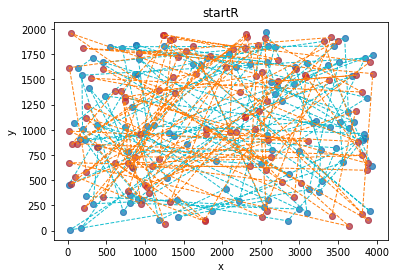

wyniki algorytmu
38127
41344
39487.6
czas obliczeń
11158.158
11552.694000000001
11282.4486


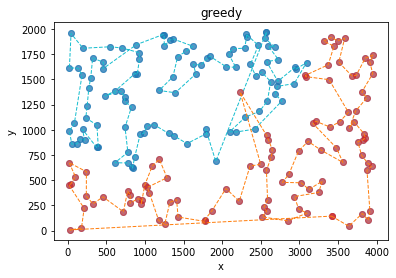

wyniki algorytmu
38920
41419
39765.0
czas obliczeń
13407.128999999999
14584.211
14170.184999999998


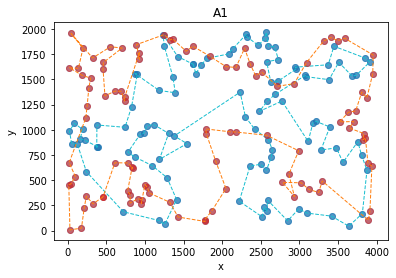

wyniki algorytmu
39049
41046
40086.6
czas obliczeń
13019.923
14651.647
13992.975


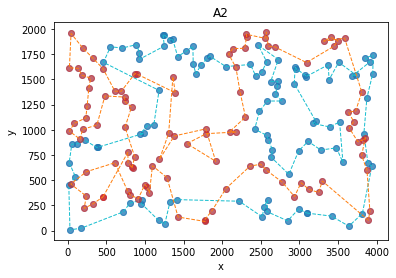

In [331]:
summarizeStart(resultStartR, resultValStartR, "startR", dataArrA)
summarize(resultGreedy, resultValGreedy, timeGreedy, "greedy", dataArrA)
summarize(resultA1, resultValA1, timeA1, "A1", dataArrA)
summarize(resultA2, resultValA2, timeA2, "A2", dataArrA)

In [332]:
resultGreedy = []
resultValGreedy = []
timeGreedy = []

resultStartR = []
resultValStartR = []

resultA1 = []
resultValA1 = []
timeA1 = []

resultA2 = []
resultValA2 = []
timeA2 = []

startingPoints = dict()
LM = dict()

In [333]:
startingPoints = dict()
runExperiment('B')

wyniki algorytmu
[327641]
[349978]
[335652.8]


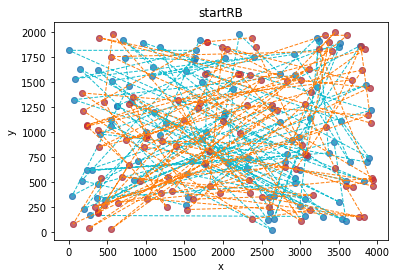

wyniki algorytmu
36000
40680
38094.8
czas obliczeń
11544.864
12638.203000000001
12006.604000000001


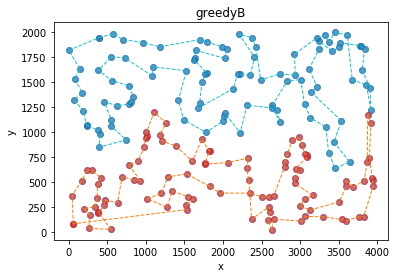

wyniki algorytmu
38741
40769
39654.4
czas obliczeń
12414.585000000001
15240.706
13752.132800000001


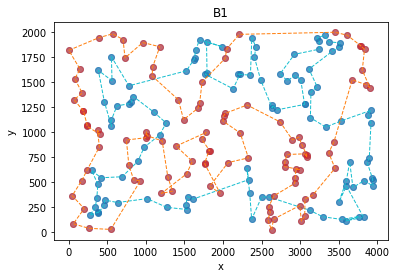

wyniki algorytmu
39740
41285
40660.6
czas obliczeń
13322.702
15423.469000000001
14229.035399999999


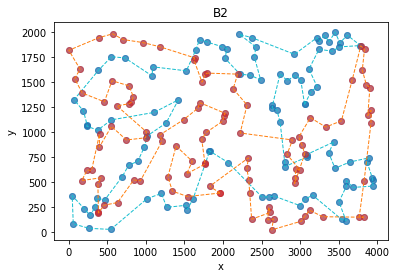

In [334]:
summarizeStart(resultStartR, resultValStartR, "startRB", dataArrB)
summarize(resultGreedy, resultValGreedy, timeGreedy, "greedyB", dataArrB)
summarize(resultA1, resultValA1, timeA1, "B1", dataArrB)
summarize(resultA2, resultValA2, timeA2, "B2", dataArrB)